Primero importaremos la librería pandas para leer la base de datos y mostraremos los tipos de datos de cada variable

In [112]:
import pandas as pd

df = pd.read_csv("A1.5 Calificaciones.csv")
print(df.dtypes)


Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object


Aquí podemos ver que las variables de Escuela, Sexo e Internet, así como HorasDeEstudio, son variables categóricas, las primeras 3 siendo posibles de representar tan solo con valores booleanos, mientras que las horas de estudio se dividen en 4 categorías. Debido a esto, pasaremos las primeras 3 variables a booleanas y dividiremos la variable de HorasDeEstudio entre 3 categorías: Horas_2, Horas_3, Horas_4, cada una representando una de las categorías de esta variable mediante booleanos, mientras que el estar todas en falso representará la primera categoría.

In [113]:
import numpy as np

df = pd.get_dummies(df, drop_first=True)

dummies_horas = pd.get_dummies(df["HorasDeEstudio"], prefix="Horas", drop_first=True)
#si es 1, tendrá las 3 secciones como false
df = pd.concat([df, dummies_horas], axis=1)
df = df.drop("HorasDeEstudio", axis=1)

print(df.head())


   Edad  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
0    18           0       6   5   6   6       False   False         False   
1    17           0       4   5   5   6       False   False          True   
2    15           3      10   7   8  10       False   False          True   
3    15           0       2  15  14  15       False   False          True   
4    16           0       4   6  10  10       False   False         False   

   Horas_2  Horas_3  Horas_4  
0     True    False    False  
1     True    False    False  
2     True    False    False  
3    False     True    False  
4     True    False    False  


Ahora buscaremos los outliers

In [114]:
Q1 = df.Faltas.quantile(0.25)
Q3 = df.Faltas.quantile(0.75)
IQR = Q3 - Q1

li = Q1 - 3*IQR
ls = Q3 + 3*IQR

outliers = np.where((df.Faltas<=li) | (df.Faltas>=ls))[0]
df = df.drop(outliers, axis=0)

print(df.iloc[outliers,:])

     Edad  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
75     15           0       6   9   9  10       False    True          True   
185    17           0      12  12  12  11       False    True          True   
279    18           0       8  10  11  10       False    True          True   
311    19           0      20  14  12  13       False   False          True   
320    17           0      23  13  13  13       False   False          True   

     Horas_2  Horas_3  Horas_4  
75      True    False    False  
185     True    False    False  
279    False    False    False  
311     True    False    False  
320     True    False    False  


Después de obtener las variables con valores atípicos, los eliminaramos porque, si bien no representan valores erróneos, representan valores extremos poco frecuentes que pueden distorsionar el modelo de regresión lineal.

Por otra parte, para la correcta generación del heatmap, convertiremos todos los valores booleanos a int que se reconozcan mediante 0 y 1

Indices: 4 5
Variables correspondientes: G2 y G3
Coeficiente de correlación: 0.9047966735871248


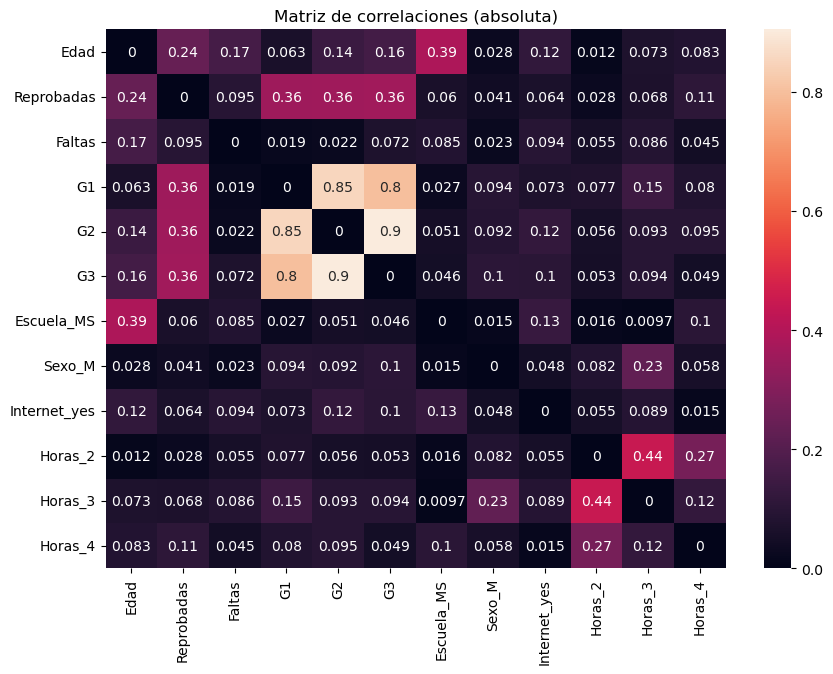

In [115]:
from seaborn import heatmap
import matplotlib.pyplot as plt

# Convertir booleanos a enteros
df = df.astype(int)

cor = df.corr().abs() 

np.fill_diagonal(cor.values, 0)
i, j = np.unravel_index(cor.values.argmax(), cor.shape)
print("Indices:",i,j)
print("Variables correspondientes:", cor.columns[i], "y", cor.columns[j])
print("Coeficiente de correlación:", cor.values[i, j])

plt.figure(figsize=(10,7))
heatmap(cor, annot=True)
plt.title("Matriz de correlaciones (absoluta)")
plt.show()


Tras generar una matriz de correlaciones y un heatmap, al observarlo, podemos notar cómo es que hay alta colinealidad entre las variables G1, G2 y G3. \
Debido a que la variable G3 es nuestra variable dependiente y a que existe una alta correlación tanto con G1 como con G2, se tomó la decisión de no eliminar ninguna variable para mantener nuestra capacidad de predicción al máximo.

Ahora incluiremos variables que representen la interacción entre dos variables. Particularmente veremos la interacción entre las variables G1 y faltas. Esto lo podemos interpretar para asociar sus calificaciones durante el primer periodo según la cantidad de faltas que tenga, dando la oportunidad a identificar factores como que entre más falte a clases, peor calificación tendrá (o al revés).
La otra interacción será entre las variables Internet_yes y Reprobadas, lo que nos servirá de manera similar a tratar de averiguar si el acceso a internet representa una diferencia entre la cantidad de materias reprobadas de un alumno, siendo posible interpretarse como que el acceso a internet puede llegar a distraerlo o del estudio en casa. Por lo tanto, si tiene un número diferente de 0, podemos asumir que tiene tanto internet, como materias reprobadas.

In [116]:
df["G1xFaltas"] = df["G1"] * (df["Faltas"] )
df["ReprobadasxInternet"] = df["Reprobadas"] * df["Internet_yes"]

print(df.head())

   Edad  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
0    18           0       6   5   6   6           0       0             0   
1    17           0       4   5   5   6           0       0             1   
2    15           3      10   7   8  10           0       0             1   
3    15           0       2  15  14  15           0       0             1   
4    16           0       4   6  10  10           0       0             0   

   Horas_2  Horas_3  Horas_4  G1xFaltas  ReprobadasxInternet  
0        1        0        0         30                    0  
1        1        0        0         20                    0  
2        1        0        0         70                    3  
3        0        1        0         30                    0  
4        1        0        0         24                    0  


                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     123.7
Date:                Thu, 28 Aug 2025   Prob (F-statistic):          1.13e-111
Time:                        07:24:44   Log-Likelihood:                -630.59
No. Observations:                 312   AIC:                             1289.
Df Residuals:                     298   BIC:                             1342.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.9185    

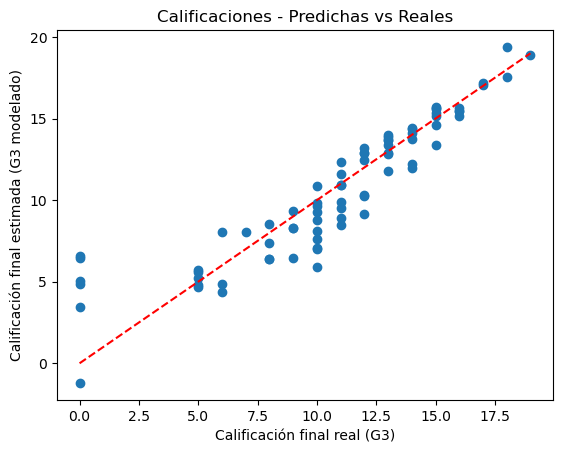

In [117]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X = df.drop("G3", axis=1)
y = df["G3"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

modelo = sm.OLS(y_train, X_train).fit()

print(modelo.summary())

y_pred = modelo.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("Calificación final real (G3)")
plt.ylabel("Calificación final estimada (G3 modelado)")
plt.title("Calificaciones - Predichas vs Reales")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  # línea ideal
plt.show()


La gráfica muestra que el modelo de regresión lineal múltiple obtenido, podemos ver que la mayoría de las observaciones se alinean con la diagonal ideal graficada, por lo que podemos notar que se adecúa considerablemente a la tendencia entre las variables que utilizamos para predecir y la calificación final. Sin embargo, también podemos notae que hay algunas observaciones dispersas a la línea ideal, particularmente con los valores más bajos de G3, lo que indica que el modelo no es perfecto y que existen otros factores fuera del dataset que también influyen en el desempeño estudiantil.  